# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Recap on Frequentist and Bayesian Hypothesis Testing
Week 11 | Lesson 5.1

In [1]:
from __future__ import print_function, division
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
%matplotlib inline

We've already talked about various statistical methods from both a frequentist and Bayesian perspective, but let's briefly recap some of the most important and compare the two approaches. Bayesian methods, although initially formalised earlier (late 18th century) than frequentist, or Fisherian, methods (early 20th century), have been gaining greater prominence in recent decades owing to the increased availability of the computational power required for the Monte Carlo sampling methods employed. Generally statistics taught at undergraduate level has focussed on frequentist methods, and Bayesian methods have tended to be covered only at the postgraduate level. Within the physical and social sciences, and within many businesses, frequentist statistics are still considered the standard. This is changing as the clear utility of the Bayesian approach is evangelised further, and the computational methods become more straightforward. It seems possible that at some point frequentist methods might be abandoned entirely. We have focussed on pymc3 as the most straightforward and accessible way to perform Bayesian analysis, which is a module still under quite heavy development. Other widely used tools include BUGS, JAGS, and STAN (all of which are more widely used in their R implementations than in Python).

## Null Hypothesis Significance Testing (NHST)

The goal of inference in NHST is to decide whether a particular parameter of a model under investigation can be rejected; in particular, it is important to remember that the parameter's acceptance is not actually implied. Let's consider an example; we wish to test whether users of our app are equally likely to be male or female. We start with the assumption that males and females are in equal numbers in the population (with apologies to the transgendered); hence we wish to test whether the ratio between them amongst users of our app is 0.5. After 260 users sign up, we have 120 females and 140 males. Are our users more male than female? 

In frequentist statistics the answer will actually depend on how the experiment was performed. That is to say, we must test some sampling space; we can here test the probability of getting 120 females out of 260 signups given a null hypothesis that the ratio between users is 0.5. However, perhaps we did not design our experiment to stop after 260 signups, but perhaps instead to last one hour, one day, etc and to stop after the fixed time period and not a specific number of signups. In this case if the experiment were repeated we might expect a different number of signups, and hence we should consider the space of all possible total signups when calculating a probability. The observed data (people signing up) of course do not modify their actions based on our testing intentions, so this presents a philosophical problem at the heart of NHST. Bayesian methods can overcome this, and the claim that Bayesian methods are subjective owing to the use of priors can surely be laid to rest in that they more objectively view the data without a somewhat confused dependence on the experimental design.

In NHST, we typically reject the null hypothesis if there is less than a 5% probability that the result seen would be expected under that hypothesis. Hence if there is a less than 5% probability of seeing 120 females out of 260 given the null hypothesis that men and women sign up equally, we reject that hypothesis and say the signup rate is distinct for the two genders. Under no circumstance do we accept the hypothesis that the two genders are the same; we only state there is insufficient evidence to reject it. But how do we find this probability? First we can generate a sampling distribution from the binomial distribution, given the fixed number of 260 signups ($N$). This tells us the probability of any given observation, typically termed $z$, given our hypothesis $\theta$, which in this case is the ratio 0.5, and the total number $N$.

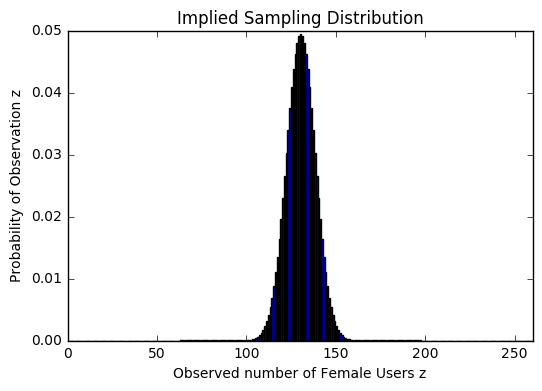

In [2]:
# Probability mass function showing the implied sampling distribution in N=260 and theta=0.5

distr=stats.binom(260, 0.5)
x=np.arange(0,260,1)
plt.bar(x, distr.pmf(x))
plt.title("Implied Sampling Distribution")
plt.ylabel("Probability of Observation z")
plt.xlabel("Observed number of Female Users z")
plt.xlim([0,260])
plt.show()

Using this probability mass function (PMF), we can determine that the probability of obtaining an observation of 120 is:

In [3]:
distr.pmf(120)

0.022957165973791088

Or 2.3%. However, this is not really what we are looking for. Actually we want to know the probability of obtaining a result at least as extreme as the one we saw. Furthermore, we are often also interested in the case where z is high - since this also equally implies a lack of equality (this is the distinction of a two-tailed test versus a one-tailed). That total probability is then what we refer to as the p-value. We can find this using the cumulative distribution function (CDF):

In [4]:
distr.cdf(120)

0.11930361780526047

Hence we say we do not have enough evidence to reject the null hypothesis (that the ratio between the users' sex is 0.5).

If we are interested in where the critical region is we can see the result from this function is 116 for the highest integer value of $z$ that returns a p-value below 0.05, or if we consider the two-tailed test then we need the p-value to be 0.025 to the left (since it is a symmetric function, there will hence also be 0.025 to the right). Hence for the two tailed we need a z value at least as extreme as 113 or 147, as confirmed by the cdf of 113 being below 0.025.

In [5]:
distr.cdf(116)

0.046924110243129868

In [6]:
distr.cdf(113)

0.020246979371918654

In [13]:
distr.cdf(146)

0.97975302062808134

This means that if we wish to consider the question: is an observed number of females 120 expected or do we believe this represents a statistically significant deviation from the expectation that male and female numbers of signups should be equal? Then our answer in this case is that we do not have sufficient evidence to reject the null hypothesis that there is an equal ratio of men and women in this case, since we would need to see a $z$ value of 113 or less or 147 or greater in order to do so.

We considered here the case that the number $N$ was fixed, but what if instead we conducted the experiment until we reached a fixed $z$ - which was 120. Then it is $N$ that varies. This is actually a distinct case and strictly speaking this does matter for frequentist interpretation, though this is often overlooked.

For the Bayesian case, in general we would set a prior that would relate to past information we have on our user base, such as the total number of users in the app's history. This is appropriate in that it allows us to define how strong the lean to a ratio other than 0.5 would have to be before we would be convinced by it - this is just how you would tend to think about the problem naturally. However in this case we will use an uninformative prior that is flat since we do not have other information (in general that's unrealistic though). Recall the syntax of pymc3 we studied before.

In [15]:
observations=[0]*120+[1]*140
print(observations)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [7]:
with pm.Model() as model:
    probability = pm.Uniform('theta', lower=0, upper=1)
    likelihood = pm.Bernoulli('likelihood', p=probability, observed=observations)
    trace = pm.sample(5000)

Applied interval-transform to theta and added transformed theta_interval_ to model.
Assigned NUTS to theta_interval_
100%|██████████| 5000/5000 [00:06<00:00, 797.16it/s] 


array([<matplotlib.axes._subplots.AxesSubplot object at 0x119c20550>], dtype=object)

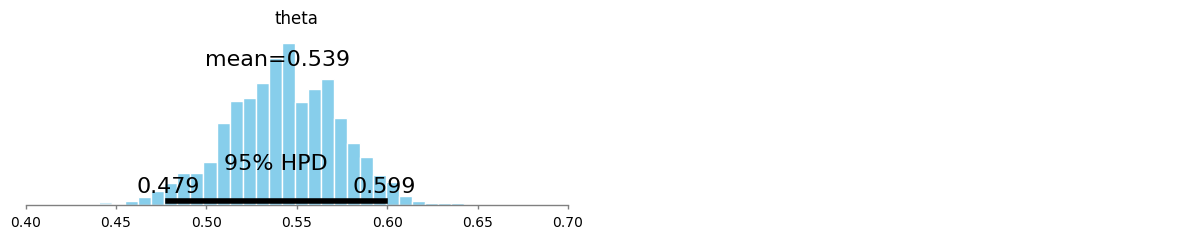

In [8]:
pm.plot_posterior(trace[2000:], color='#87ceeb')

And we instead have a much clearer view compared to the frequentist yes/no. Here we see a distribution of theta values, for which 0.5 is within the 95% Highest Posterior Density region. We have a much clearer view of what the most likely values for theta would be from this distribution and much better interpretability than a yes/no frequentist test. We also make fewer assumptions about the distribution of the data.

## Comparing two groups

Typically in a frequentist approach to compare two groups, such as for example whether the conversion rate between arms A and B of an A/B test are the same, a t-test would be performed. The most typical case would be the Welch's t-test, which accounts for unequal variances between the two groups and also unequal sample sizes. We have seen the Bayesian approach to this more than once in past exercises also. Here we will look at the conversion rate of customers in two groupings.

We might summarise the distinction between Bayesian and frequentist approaches in that: 

- a frequentist approach seeks to find $P\;(\;data\;|\;true\;conversion\;rate\;)$; given some fixed, underlying conversion rate (which in our null hypothesis is the same in both groups), what is the probability that the given data would be seen?
- a Bayesian approach seeks to find $P\;(\;true\;conversion\;rate\;|\;data\;)$; given the data seen, what is the probability of any conversion rates tested being the true underlying one?

In [9]:
# do these two groups have distinct conversion rates?

group_a=[0]*168+[1]*12
group_b=[0]*175+[1]*5
conversion=pd.DataFrame(data={"group_a": group_a, "group_b": group_b})
print(conversion["group_a"].mean())
print(conversion["group_b"].mean())

0.0666666666667
0.0277777777778


So in a frequentist test, we consider the means (i.e. the conversion rates) to be the sample, that is to say we consider that the conversion rate is distributed normally and out of the possible values that came from the underlying population(s) then these two conversion rates were sampled. So the question is whether we think they were sampled from two different distributions or not.

The t-statistic is calculated based on the differences between these two, and then we look up the t-statistic on a t-distribution with a shape specified by the degrees of freedom of the samples (calculated from the Welch–Satterthwaite equation). Hence based on both the magnitude of the differences, and also the sample size, we can arrive from the t-distribution and t-statistic at the corresponding probability of obtaining a value at least as extreme as the one seen. That's our p-value. Based on that p-vale we decide how likely it is that the values were seen given the null hypothesis. Hence if the p-value is below 0.05 we think there is only a 1 in 20 chance that the observation would be made. That is to say, if we repeated the observations 19 more times, we would expect to see a case with a p-value of 0.05 in only 1 of the 20 cases.

Note that strictly we can consider also a z-test for cases with a known variance, but in practical terms for reasonable sample sizes there is not much need to be concerned with this (you will find it simpler to stick with the t-test).

In [10]:
stats.ttest_ind(conversion["group_a"], conversion["group_b"], equal_var = False)

Ttest_indResult(statistic=1.7418089175006386, pvalue=0.082534554151970072)

To do the analysis in a Bayesian estimation we use a uniform prior and calculate a deterministic variable as A minus B which will tell us whether there is a difference between the two groups. All these cases involve uniform priors as one-off comparisons with no previous data available, but in general you would include some prior data.

In [11]:
with pm.Model():
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)
    A = pm.Bernoulli('A', p=A_p, observed=conversion["group_a"].values)
    B = pm.Bernoulli('B', p=B_p, observed=conversion["group_b"].values) 
    AvB = pm.Deterministic('AvB', A_p - B_p)
    start=pm.find_MAP()
    trace = pm.sample(10000, start=start)

Applied interval-transform to A_prob and added transformed A_prob_interval_ to model.
Applied interval-transform to B_prob and added transformed B_prob_interval_ to model.
Assigned NUTS to A_prob_interval_
Assigned NUTS to B_prob_interval_
100%|██████████| 10000/10000 [00:09<00:00, 1062.38it/s]


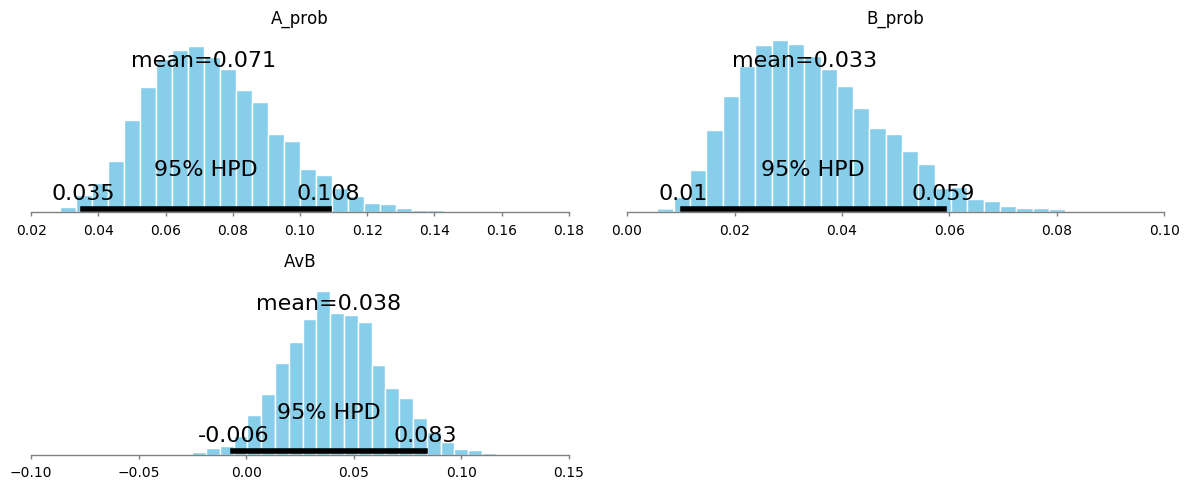

In [12]:
# It is the third figure we are interested in, showing the AvB case which indicates whether the no-difference
# case is within the 95% Highest Posterior Density region

pm.plot_posterior(trace[1000:], color='#87ceeb')
plt.show()

## Comparing more than two groups

When comparing more than two groups in a frequentist approach, one must be careful not to separately compare each group to each other group without thought to the statistical implications. Since we typically use a p-value of 0.05, we are saying that there is a (less than) 5% chance of accidentally rejecting the null hypothesis when the null hypothesis is true. However clearly if you make many such comparisons, the probability that any one of them will be wrong by chance is then greater than 5%. There are several usual approaches to dealing with this, one of the most common and straightforward being the Bonferroni correction. This involves very simply making the p-value required more stringent by dividing the condition 0.05 by the number of comparisons. There are many other such possible corrections; another popular one is Tukey's Honest Significant Difference. Such corrections are not required for Bayesian estimation; one simply calculates each comparison of interest and compares the Highest Posterior Density region in each of the differences.

However to look at multiple groups we would generally perform analysis of variance (ANOVA), which is based on the f-test. Bear in mind that these test simply fall within the same range of statistical tests as linear regression and the Pearson correlation coefficient, which you would perform if both the explanatory and response variables were quantitative. In this case we are talking about categorical explanatory and quantitative response variables. This is still modelling; we are asking if we can predict conversion rate based on grouping. We can think of this as simply creating a linear model in which we have some base value (which is the intercept) and we add some value(s) multiplied by 0 or 1 depending if the condition is true (for multilevel groupings the single value becomes a vector of possible values).

Hence: in the case of more than two groups to test we can run multiple t-tests, we can run ANOVA f-test, we can even run linear regression. These are not fundamentally distinct operations. You could also run the f-test for two groups. The differences between the tests are simply related to their assumptions, such as equal variance within groups in ANOVA (the f-statistic in ANOVA is proportial to the ratio of the between group variance and the within group variance), that as was mentioned is not present in the t-test. Note also that, critically, Bayesian estimation essentially does away with such considerations. 



In [16]:
group_a=[0]*168+[1]*12
group_b=[0]*175+[1]*5
group_c=[0]*160+[1]*20
conversion=pd.DataFrame(data={"group_a": group_a, "group_b": group_b, "group_c": group_c})
print(conversion["group_a"].mean())
print(conversion["group_b"].mean())
print(conversion["group_c"].mean())

0.0666666666667
0.0277777777778
0.111111111111


In [17]:
# this result is essentially the same as the previous result for the t-test
# but the t-test only works for two groups - note that "oneway" refers to a single
# predictor being tested

stats.f_oneway(conversion["group_a"], conversion["group_b"])

F_onewayResult(statistic=3.0338983050847452, pvalue=0.082400765571645759)

So why not just do the f-test under all conditions if it works for both two groups and more than two?

In [18]:
# this is the result for the three groups - there is definitely a difference between the three groups
# but are they all different from each other or maybe just one is different and the other two are
# the same? ANOVA f-test does not tell us

stats.f_oneway(conversion["group_a"], conversion["group_b"], conversion["group_c"])

F_onewayResult(statistic=4.9665079625677251, pvalue=0.0072908633561833275)

So we can now do multiple t-tests with a Bonferonni correction to the critical p-value.

In [19]:
# only the comparison of group b and group c yields a p-value which is below the new
# critical value of 0.05/3 = 0.017

print(stats.ttest_ind(conversion["group_a"], conversion["group_b"], equal_var = False))
print(stats.ttest_ind(conversion["group_b"], conversion["group_c"], equal_var = False))
print(stats.ttest_ind(conversion["group_a"], conversion["group_c"], equal_var = False))

Ttest_indResult(statistic=1.7418089175006386, pvalue=0.082534554151970072)
Ttest_indResult(statistic=-3.1437931838500579, pvalue=0.0018537532920790947)
Ttest_indResult(statistic=-1.4819983192989483, pvalue=0.13926570485787521)


In [20]:
with pm.Model():
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)
    C_p = pm.Uniform('C_prob', lower=0, upper=1)
    A = pm.Bernoulli('A', p=A_p, observed=conversion["group_a"].values)
    B = pm.Bernoulli('B', p=B_p, observed=conversion["group_b"].values) 
    C = pm.Bernoulli('C', p=C_p, observed=conversion["group_c"].values) 
    AvB = pm.Deterministic('AvB', A_p - B_p)
    BvC = pm.Deterministic('BvC', B_p - C_p)
    AvC = pm.Deterministic('AvC', A_p - C_p)
    start=pm.find_MAP()
    trace = pm.sample(10000, start=start)

Applied interval-transform to A_prob and added transformed A_prob_interval_ to model.
Applied interval-transform to B_prob and added transformed B_prob_interval_ to model.
Applied interval-transform to C_prob and added transformed C_prob_interval_ to model.
Assigned NUTS to A_prob_interval_
Assigned NUTS to B_prob_interval_
Assigned NUTS to C_prob_interval_
100%|██████████| 10000/10000 [00:12<00:00, 793.30it/s]


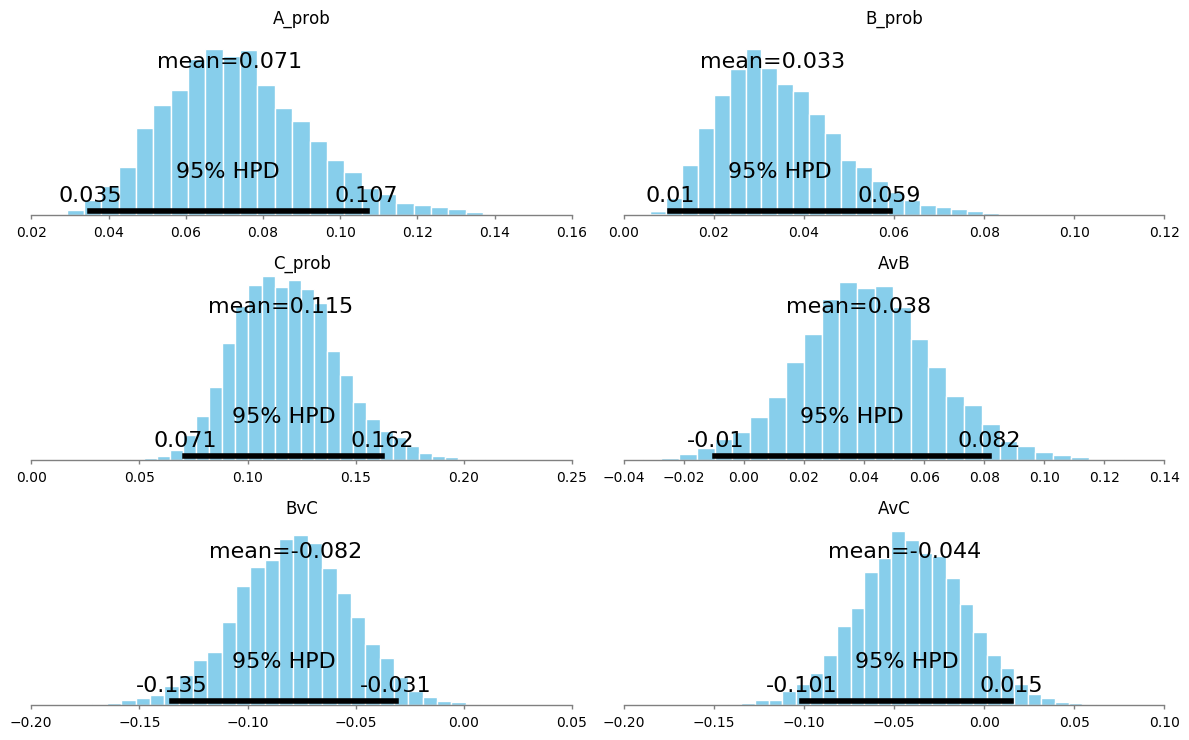

In [21]:
# which of the differences has its entire Highest Posterior Density region outside of
# a 0 value? Note we also get some more information about just how different the other
# groups are from each other that is substantially more interpretable than p-values

pm.plot_posterior(trace[1000:], color='#87ceeb')
plt.show()

## Some problems

Note that some of these were not directly covered in this recap but have been covered previously.

1) A hypothesis test is done in which the alternative hypothesis is that more than
10% of a population is left-handed. The p-value for the test is calculated to be
0.25. Which statement is correct?
- a) We can conclude that more than 10% of the population is left-handed.
- b) We can conclude that more than 25% of the population is left-handed.
- c) We can conclude that exactly 25% of the population is left-handed.
- d) We cannot conclude that more than 10% of the population is left-handed. 

2) A Type I error is committed when
- a) we reject a null hypothesis that is true.
- b) we don't reject a null hypothesis that is true.
- c) we reject a null hypothesis that is false.
- d) we don't reject a null hypothesis that is false. 

3) A Type II error is committed when
- a) we reject a null hypothesis that is true.
- b) we don't reject a null hypothesis that is true.
- c) we reject a null hypothesis that is false.
- d) we don't reject a null hypothesis that is false. 

4) A researcher has a theory that the average age of managers in a particular industry
is over 35-years-old, and he wishes to prove this. The null hypothesis to conduct
a statistical test on this theory would be:
- a) the population mean is < 35
- b) the population mean is >= 35
- c) the population mean is = 35
- d) the population mean is > 35 

5) A company believes that it controls more than 30% of the total market share for
one of its products. To prove this belief, a random sample of 144 purchases, of
this product are contacted. It is found that 50 of the 144 purchased this company's
brand of the product. If a researcher wants to conduct a statistical test for this
problem, the alternative hypothesis would be:

- a) the population proportion is less than 0.30
- b) the population proportion is greater than 0.30
- c) the population proportion is not equal to 0.30
- d) the population mean is less than 40 

6) A mileage test is conducted for a new car model, the “Pizzazz.” Thirty (n=30) random
selected Pizzazzes are driven for a month and the mileage is carefully measured in each and the samples are below. Estimate a 95% confidence interval for the mean mpg in the entire population of Pizzazzes. Note that the standard deviation for the population is not the standard deviation of the sample (look this up for the correction required). Note this is not a hypothesis test so there is not a question of Bayesian/frequentist equivalence.

In [81]:
samples6=[ 28.29,  27.28,  29.7 ,  25.67,  31.39,  28.93,  27.08,  25.59,
        32.55,  26.67,  26.59,  26.84,  33.23,  25.99,  25.63,  30.08,
        25.18,  28.05,  24.83,  29.44,  28.45,  29.93,  27.82,  30.55,
        29.6 ,  25.88,  25.4 ,  30.42,  27.55,  29.19]

7) Test the null hypothesis that the following geographic groupings of customers have the same conversion rate and investigate by frequentist and Bayesian approaches.

In [120]:
london=105*[0]+256*[1]
southeast=78*[0]+271*[1]
north=69*[0]+38*[1]
wales=20*[0]+20*[1]